<a href="https://colab.research.google.com/github/R-Jin/bird-song-classifier/blob/main/bird_song_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare dataset location

In [1]:
from google.colab import drive

# Mount Google Drive
drive.flush_and_unmount()
drive.mount('/content/drive')

# Setup target directory
target_dir = "/content/drive/MyDrive/birdclef-2025"

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# Imports

In [2]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import librosa.display

# Constants

In [3]:
BATCH_SIZE = 32

SAMPLE_RATE = 32000

# Read dataset

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/birdclef-2025/train.csv")

unique_bird_species = train_df['primary_label'].nunique()
unique_song_types = train_df['type'].nunique()

print(f"Number of unique bird species: {unique_bird_species}")
print(f"Number of unique song types: {unique_song_types}")

Number of unique bird species: 206
Number of unique song types: 736


In [5]:
unwanted_labels = [
    'uncertain', 'frog', 'frogs', 'car', 'plane', 'wind', 'river', 'surf',
    'motor', 'insect', 'noise', 'background', 'voices', 'human', 'dog',
    'perro', 'cow', 'latido', 'engine', 'traffic', 'urban', 'música',
    'music', 'unknown', 'no idea', '?', 'nao', 'não', 'environmental',
    'ambient', 'dogs', 'bird in h', 'laughing', 'hits', 'chatter', 'mechanical', 'imitation',
]

canonical_labels = {
    'song': ['song', 'songs', 'full song', 'complete song', 'alternate song', 'display song', 'morning song', 'evening song', 'day song', 'dawn song', 'vesper song', 'nuptial song', 'predawn song'],
    'call': ['call', 'calls', 'typical call', 'short call', 'long call', 'flight call', 'begging call', 'alarm call', 'chase call', 'contact call', 'feeding call', 'distress call', 'display call', 'excited call', 'juvenile call'],
    'alarm call': ['alarm call', 'alarm calls', 'alarm', 'alarm whistle', 'alarm call?', 'alarm call in flight'],
    'flight call': ['flight call', 'calls in flight', 'call in flight', 'flight calls', 'take-off calls', 'take-off call'],
    'duet': ['duet', 'duet song', 'duet call', 'couple duet', 'song and duet', 'duetting'],
    'drum': ['drum', 'drumming', 'bill snap', 'bill snapping', 'wing beat', 'wing flaps', 'wing noise', 'wing flutter', 'wing flutters', 'wing sounds', 'wing whirr', 'wing whirrs', 'wing snaps', 'bill/wing snapping'],
    'subsong': ['subsong', 'subsong?', '"subsong"'],
    'trill': ['trill', 'trilled call', 'trill call', 'cooing trill'],
    'display': ['display', 'display song', 'display call', 'song during display flight', 'display song & instrumental wings noise'],
}


In [6]:
import re

unique_labels = []

song_labels = train_df['type'].unique().tolist()


for x in song_labels:
  results = re.findall(r"'([^']*)'", x)
  for result in results:
    if result not in unique_labels:
      unique_labels.append(result)

print(unique_labels)
print(len(unique_labels))

['', 'advertisement call', 'territorial call', 'flight call', 'chorus', 'uncertain', 'call', 'agressive call', 'song', 'alarm call', 'calls', 'flight calls', 'call (in flight)', 'song while displaying', 'begging call', 'young calling from the nest', 'call in flight', 'feeding call', '3 indiv', 'alarm call?', 'hatchling or nestling', 'drumming', 'klee series', 'canto', 'splash', 'partial song', 'nocturnal flight call', 'subsong', 'immature male', 'chase call', 'day song', '(flight?) calls', 'take-off calls', 'canto de voo', 'chamado', 'duet', 'flight song', 'call and song in flight', 'calls on takling flight', 'estridulación', 'frogs', 'contact calls', 'llamado de cría', 'musical calls', 'aberrant', 'duet song. calls', 'excited call', 'alarm calls', 'agitated calls', 'canto longo variado', 'call (siren call)', 'dueto', 'anfibios', 'bill rattle', 'wing beats', 'songs', 'couple duet', 'song with several variations. all sounds made by wtst.', 'rattle', 'music in far back', 'plane', 'wing n

In [7]:
#print(train_df['type'].unique())
print(train_df['primary_label'].unique())
print(len(train_df['primary_label'].unique()))

['1139490' '1192948' '1194042' '126247' '1346504' '134933' '135045'
 '1462711' '1462737' '1564122' '21038' '21116' '21211' '22333' '22973'
 '22976' '24272' '24292' '24322' '41663' '41778' '41970' '42007' '42087'
 '42113' '46010' '47067' '476537' '476538' '48124' '50186' '517119'
 '523060' '528041' '52884' '548639' '555086' '555142' '566513' '64862'
 '65336' '65344' '65349' '65373' '65419' '65448' '65547' '65962' '66016'
 '66531' '66578' '66893' '67082' '67252' '714022' '715170' '787625'
 '81930' '868458' '963335' 'amakin1' 'amekes' 'ampkin1' 'anhing' 'babwar'
 'bafibi1' 'banana' 'baymac' 'bbwduc' 'bicwre1' 'bkcdon' 'bkmtou1'
 'blbgra1' 'blbwre1' 'blcant4' 'blchaw1' 'blcjay1' 'blctit1' 'blhpar1'
 'blkvul' 'bobfly1' 'bobher1' 'brtpar1' 'bubcur1' 'bubwre1' 'bucmot3'
 'bugtan' 'butsal1' 'cargra1' 'cattyr' 'chbant1' 'chfmac1' 'cinbec1'
 'cocher1' 'cocwoo1' 'colara1' 'colcha1' 'compau' 'compot1' 'cotfly1'
 'crbtan1' 'crcwoo1' 'crebob1' 'cregua1' 'creoro1' 'eardov1' 'fotfly'
 'gohman1' 'grasa

In [27]:
# Generated with gemini
# Prompt: Create data loaders

class BirdClefDataset(Dataset):
    def __init__(self, df, target_dir, audio_transform=None):
        self.df = df
        self.target_dir = target_dir
        self.audio_transform = audio_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        audio_path = os.path.join(self.target_dir, "train_audio", row["filename"])
        try:
          waveform, sample_rate = torchaudio.load(audio_path)
        except Exception as e:
          print(f"Error loading file {audio_path}: {e}")
          # Instead of returning None, return an empty tensor and a default label
          waveform = torch.empty((0,))
          label = "unknown"
          return waveform, label

        if self.audio_transform:
          waveform = self.audio_transform(waveform)  # shape: [1, n_mels, time]
          waveform = waveform.squeeze(0)  # shape: [n_mels, time]

        label = row["primary_label"]
        return waveform, label

def collate_fn(batch):
    spectrograms, labels = zip(*batch)

    # Filter out empty
    filtered = [(s, l) for s, l in zip(spectrograms, labels) if s.numel() > 0]
    if len(filtered) == 0:
        return torch.empty(0), [], torch.empty(0)

    spectrograms, labels = zip(*filtered)

    # Transpose to [time, n_mels]
    spectrograms = [s.permute(1, 0) for s in spectrograms]

    # Pad along time
    lengths = torch.tensor([s.shape[0] for s in spectrograms])  # time steps
    padded_specs = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True)  # [B, max_time, n_mels]

    # Transpose back to [B, n_mels, time]
    padded_specs = padded_specs.permute(0, 2, 1)

    return padded_specs, labels, lengths

train_dataset = BirdClefDataset(train_df, target_dir, torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

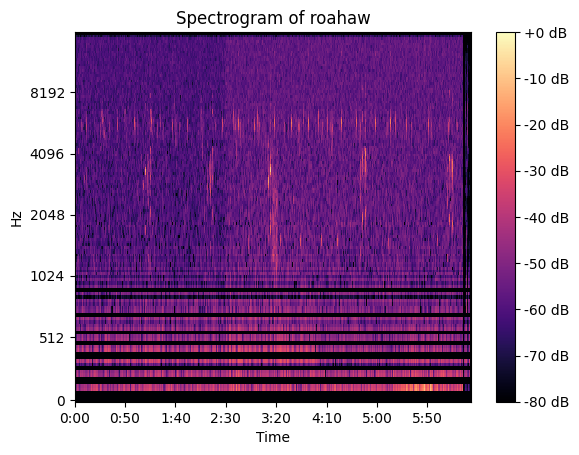

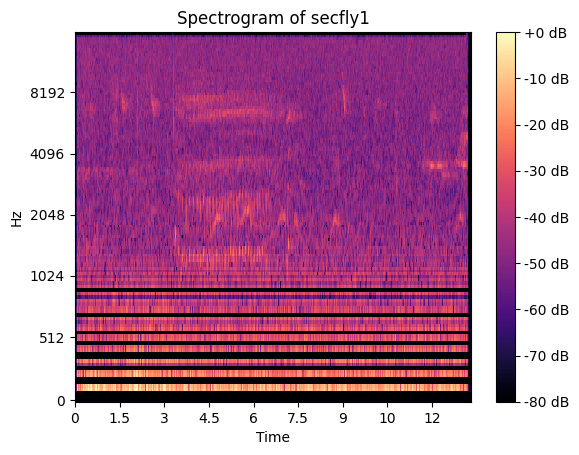

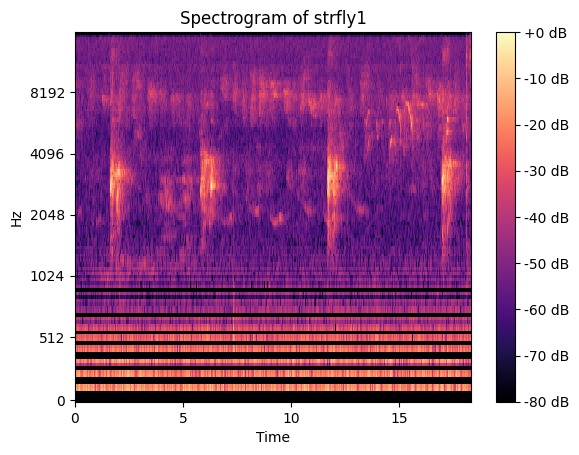

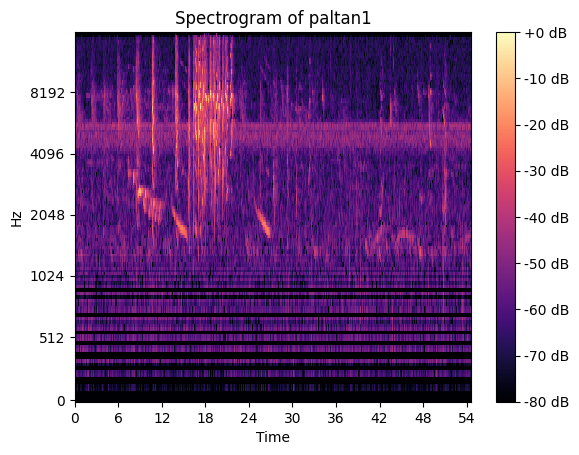

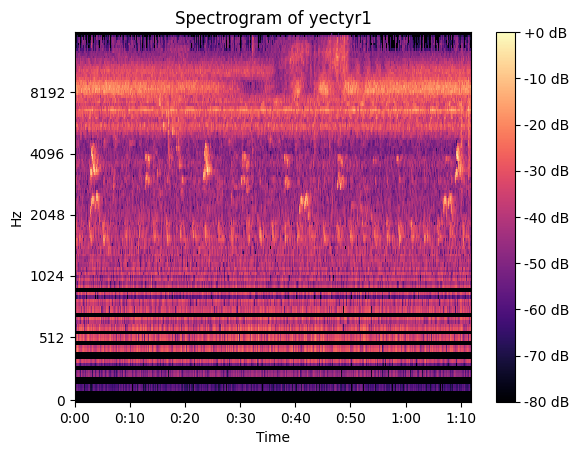

In [32]:
# Generated with GPT
# prompt: Visualise the data set

import matplotlib.pyplot as plt
import librosa.display

def visualize_spectrograms(train_loader, num_spectrograms=5):
    count = 0
    for spectrograms, labels, lengths in train_loader:
        for j in range(spectrograms.shape[0]):
            if count >= num_spectrograms:
                return  # done
            spectrogram = spectrograms[j, :, :lengths[j]].cpu().numpy()
            fig, ax = plt.subplots()
            img = librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max),
                                           x_axis='time', y_axis='mel', sr=SAMPLE_RATE, ax=ax)
            ax.set(title=f'Spectrogram of {labels[j]}')
            fig.colorbar(img, ax=ax, format="%+2.f dB")
            plt.show()
            count += 1

visualize_spectrograms(train_loader)


# Neural network


In [ ]:
# Example NN from GPT

class BirdSongClassifier(nn.Module):
    def __init__(self, num_species, num_song_types):
        super(BirdSongClassifier, self).__init__()

        # Convolutional backbone (simple CNN for now)
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 1/2 size

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape: [batch, 64, 1, 1]
        )

        # Shared feature layer
        self.shared_fc = nn.Linear(64, 128)

        # Output heads
        self.species_head = nn.Linear(128, num_species)
        self.song_type_head = nn.Linear(128, num_song_types)

    def forward(self, x):
        x = self.features(x)            # [B, 64, 1, 1]
        x = x.view(x.size(0), -1)       # [B, 64]
        x = F.relu(self.shared_fc(x))   # [B, 128]

        species_logits = self.species_head(x)
        song_type_logits = self.song_type_head(x)

        return species_logits, song_type_logits
